In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                            roc_curve, precision_recall_curve, 
                            confusion_matrix, classification_report)
from sklearn.impute import SimpleImputer
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import warnings
warnings.filterwarnings('ignore')


In [2]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
data = pd.read_csv("ami_features_24h.csv")

In [3]:
# Define target variables for different prediction horizons
target_vars = {
    'ICU Mortality': 'icu_expire_flag',
    'In-Hospital Mortality': 'hospital_expire_flag',
    '30-Day Post-Discharge Mortality': 'death_30d_post_discharge'
}

# Define feature columns (exclude IDs and target variables)
id_cols = ['subject_id', 'hadm_id', 'stay_id']
target_cols = list(target_vars.values())
feature_cols = [col for col in data.columns if col not in id_cols + target_cols]

print(f"Total samples: {len(data)}")
print(f"Number of features: {len(feature_cols)}")
print(f"\nFeatures: {feature_cols}")

Total samples: 6597
Number of features: 17

Features: ['age', 'gender', 'race', 'hypertension', 'diabetes', 'copd', 'ckd', 'heart_failure', 'hr_mean', 'hr_min', 'hr_max', 'creatinine', 'lactate', 'glucose', 'sodium', 'potassium', 'vasopressor_use']


In [4]:
# Encode categorical variables
categorical_cols = ['gender', 'race']
label_encoders = {}

for col in categorical_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le
    print(f"\n{col} encoded: {dict(zip(le.classes_, le.transform(le.classes_)))}")


gender encoded: {'F': 0, 'M': 1}

race encoded: {'AMERICAN INDIAN/ALASKA NATIVE': 0, 'ASIAN': 1, 'ASIAN - ASIAN INDIAN': 2, 'ASIAN - CHINESE': 3, 'ASIAN - KOREAN': 4, 'ASIAN - SOUTH EAST ASIAN': 5, 'BLACK/AFRICAN': 6, 'BLACK/AFRICAN AMERICAN': 7, 'BLACK/CAPE VERDEAN': 8, 'BLACK/CARIBBEAN ISLAND': 9, 'HISPANIC OR LATINO': 10, 'HISPANIC/LATINO - CENTRAL AMERICAN': 11, 'HISPANIC/LATINO - COLUMBIAN': 12, 'HISPANIC/LATINO - CUBAN': 13, 'HISPANIC/LATINO - DOMINICAN': 14, 'HISPANIC/LATINO - GUATEMALAN': 15, 'HISPANIC/LATINO - HONDURAN': 16, 'HISPANIC/LATINO - MEXICAN': 17, 'HISPANIC/LATINO - PUERTO RICAN': 18, 'HISPANIC/LATINO - SALVADORAN': 19, 'MULTIPLE RACE/ETHNICITY': 20, 'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 21, 'OTHER': 22, 'PATIENT DECLINED TO ANSWER': 23, 'PORTUGUESE': 24, 'SOUTH AMERICAN': 25, 'UNABLE TO OBTAIN': 26, 'UNKNOWN': 27, 'WHITE': 28, 'WHITE - BRAZILIAN': 29, 'WHITE - EASTERN EUROPEAN': 30, 'WHITE - OTHER EUROPEAN': 31, 'WHITE - RUSSIAN': 32}


In [5]:
# 2. handle missing values 
# Check missing values
missing_info = data[feature_cols].isnull().sum()
missing_info = missing_info[missing_info > 0].sort_values(ascending=False)
print("\nMissing values per feature:")
print(missing_info)
# Impute missing values with median for numerical features
imputer = SimpleImputer(strategy='median')
data[feature_cols] = imputer.fit_transform(data[feature_cols])
print("\nMissing values after imputation: ", data[feature_cols].isnull().sum().sum())


Missing values per feature:
lactate            2017
vasopressor_use     663
glucose              31
creatinine           23
sodium               19
potassium            19
hr_mean               8
hr_min                8
hr_max                8
dtype: int64

Missing values after imputation:  0



3. Training MLP Model for: ICU Mortality

Class distribution:
  Negative (0): 5695 (86.33%)
  Positive (1): 902 (13.67%)

Training set size: 5277
Test set size: 1320

Class weights: {0: 0.5792535675082328, 1: 3.654432132963989}

Model Architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,001 (15.63 KB)

 Non-trainable params: 224 (896.00 B)


Training the model...

Epoch 80: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 90: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 90: early stopping
Restoring model weights from the end of the best epoch: 70.

Training completed. Best epoch: 70

4. Model Evaluation
--------------------------------------------------------------------------------

Performance Metrics:
  AUROC: 0.8055
  AUPRC: 0.4599

Classification Report:
              precision    recall  f1-score   support

    Survived       0.94      0.78      0.85      1140
        Died       0.33      0.68      0.45       180

    accuracy                           0.77      1320
   macro avg       0.64      0.73      0.65      1320
weighted avg       0.86      0.77      0.80      1320


5. Generating Visualizations...
--------------------------------------------------------------------------------
Figure saved as: mlp_results_icu_mortality.png


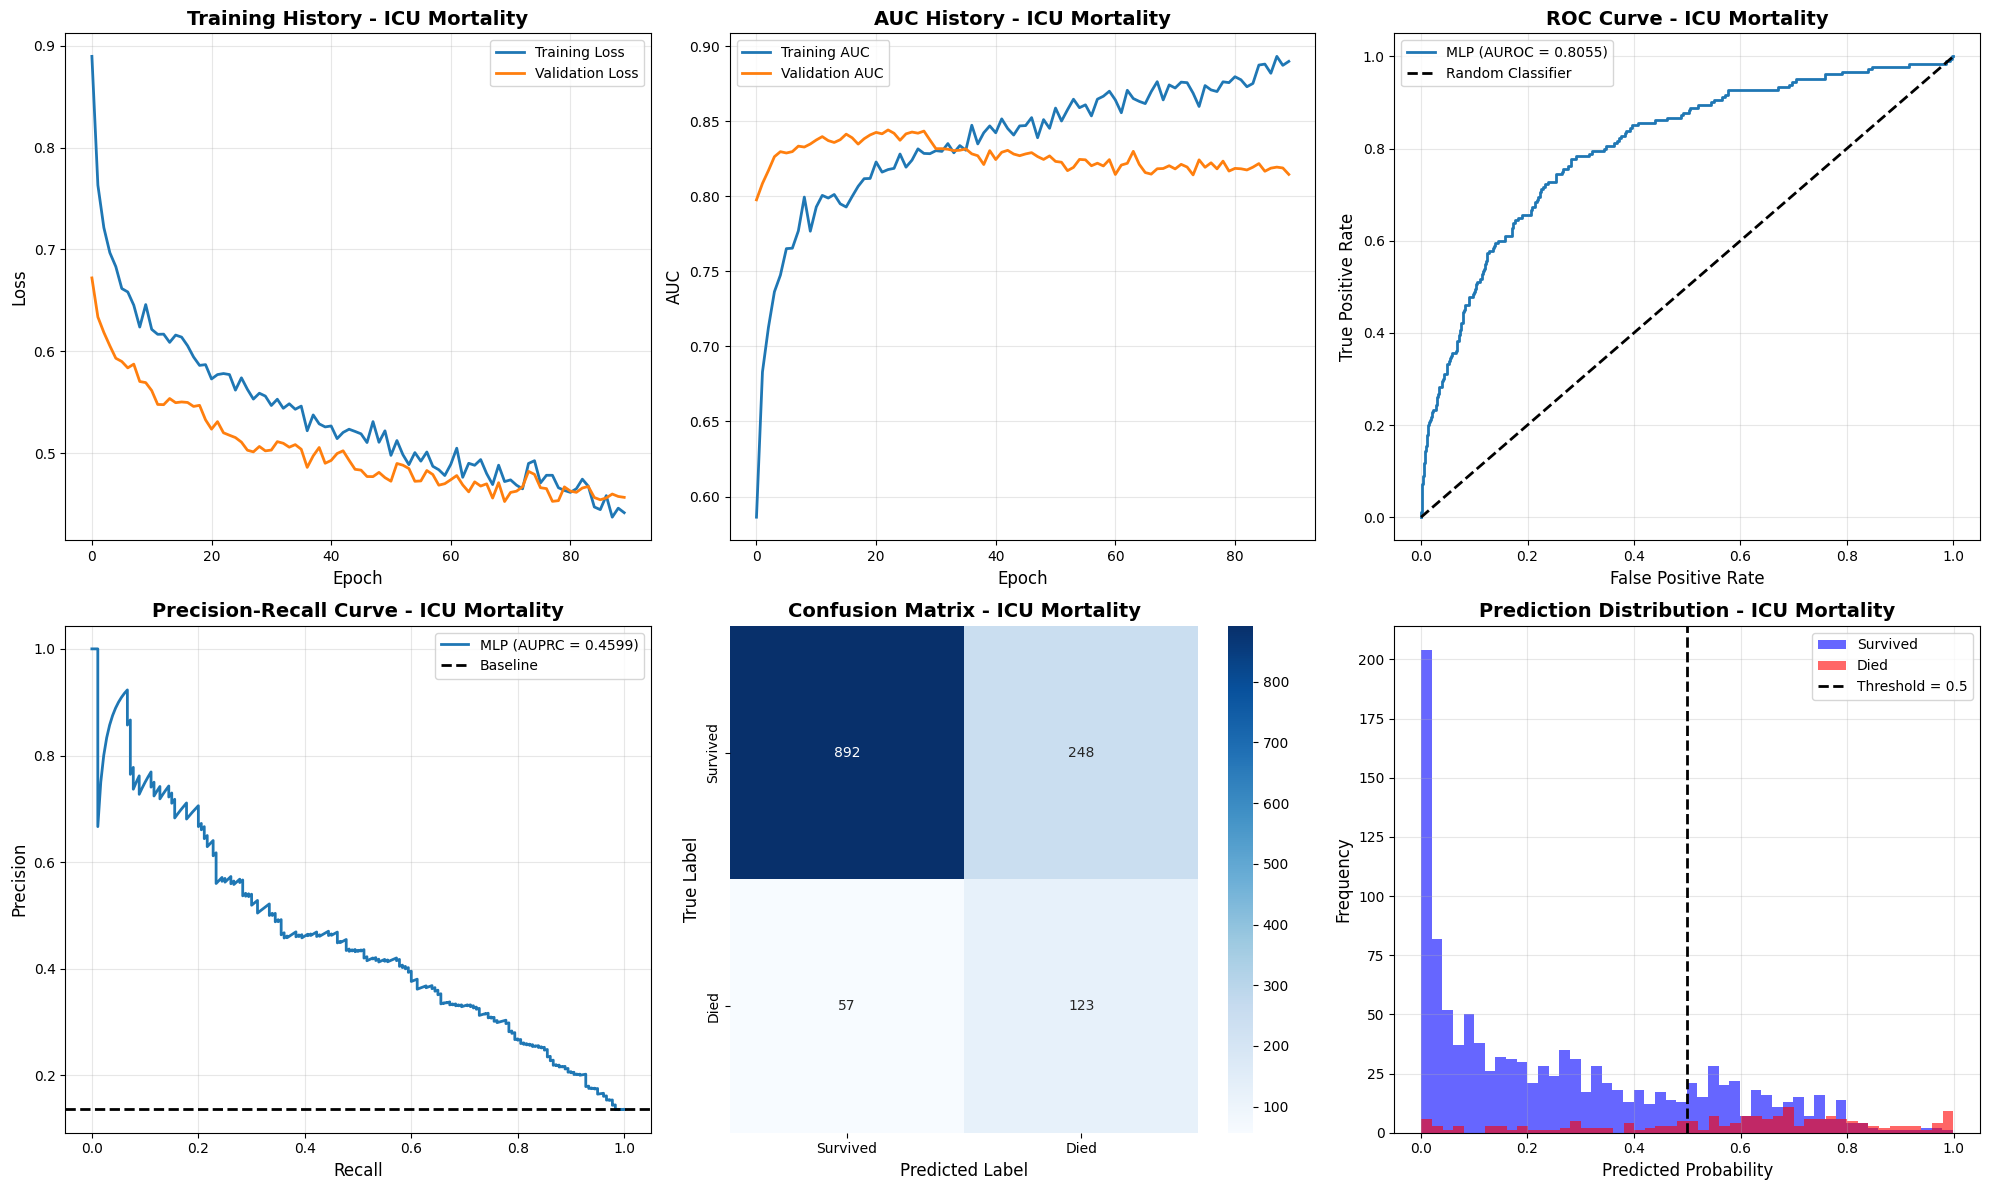


6. Computing SHAP Feature Importance...
--------------------------------------------------------------------------------
Computing SHAP values for all test samples...
SHAP values shape: (1320, 17)
X_test shape: (1320, 17)


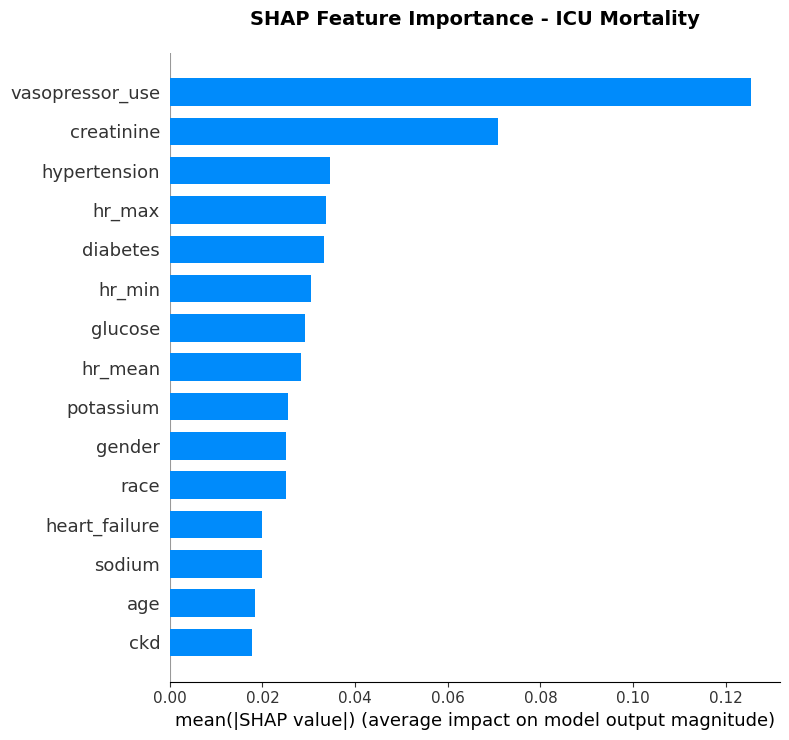


Top 10 Features for ICU Mortality:
        Feature  Importance
vasopressor_use    0.125438
     creatinine    0.070907
   hypertension    0.034527
         hr_max    0.033758
       diabetes    0.033309
         hr_min    0.030551
        glucose    0.029073
        hr_mean    0.028418
      potassium    0.025590
         gender    0.025169

3. Training MLP Model for: In-Hospital Mortality

Class distribution:
  Negative (0): 5280 (80.04%)
  Positive (1): 1317 (19.96%)

Training set size: 5277
Test set size: 1320

Class weights: {0: 0.6246448863636364, 1: 2.505698005698006}

Model Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,001 (15.63 KB)

 Non-trainable params: 224 (896.00 B)


Training the model...

Epoch 64: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.

Epoch 81: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

Epoch 91: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 91: early stopping
Restoring model weights from the end of the best epoch: 71.

Training completed. Best epoch: 71

4. Model Evaluation
--------------------------------------------------------------------------------

Performance Metrics:
  AUROC: 0.7756
  AUPRC: 0.5419

Classification Report:
              precision    recall  f1-score   support

    Survived       0.90      0.77      0.83      1056
        Died       0.41      0.64      0.50       264

    accuracy                           0.75      1320
   macro avg       0.65      0.71      0.67      1320
weighted avg       0.80      0.75      0.76      1320


5. Generating Visualizations...
--------------------------------------------------------------------------------
F

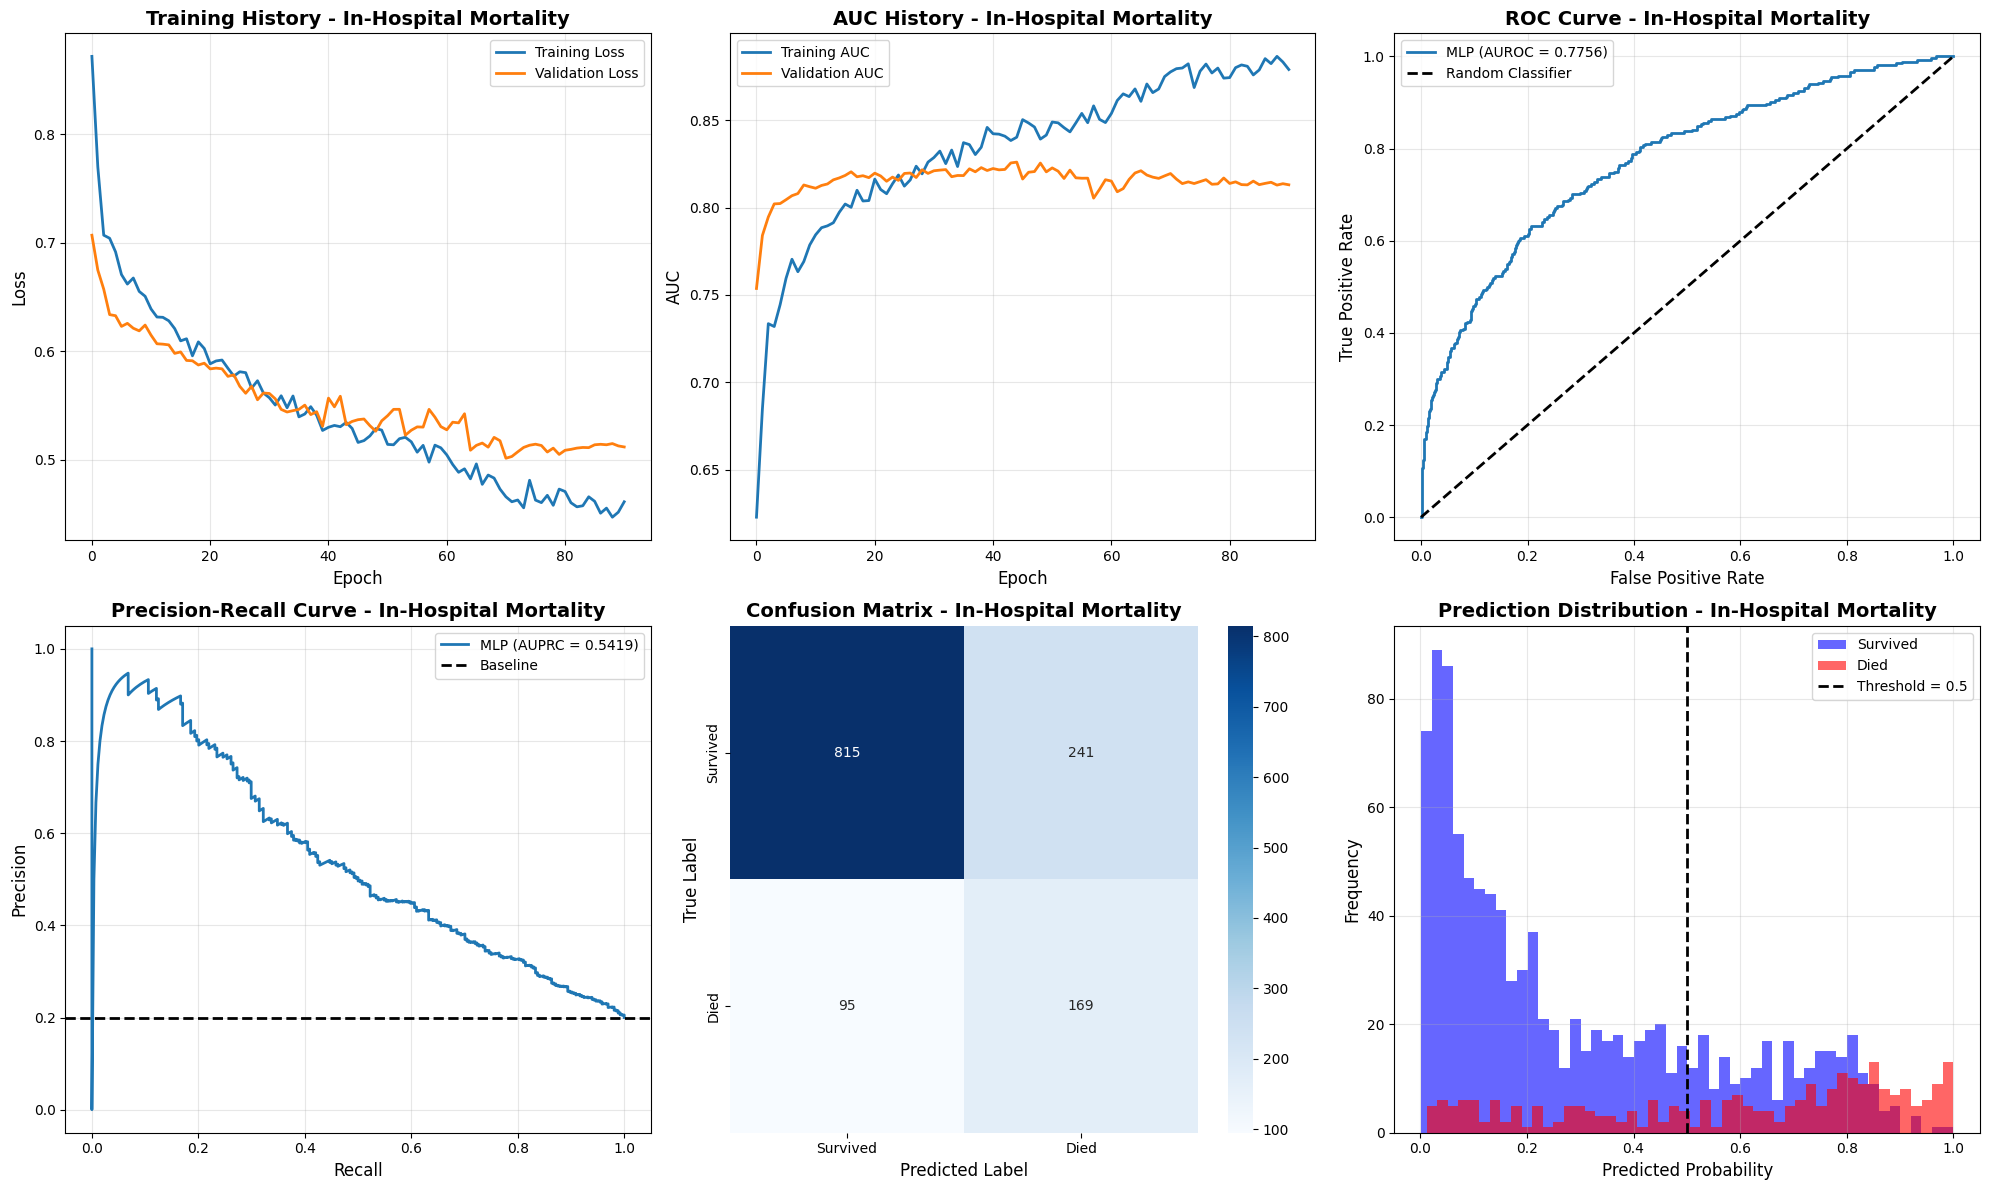


6. Computing SHAP Feature Importance...
--------------------------------------------------------------------------------
Computing SHAP values for all test samples...
SHAP values shape: (1320, 17)
X_test shape: (1320, 17)


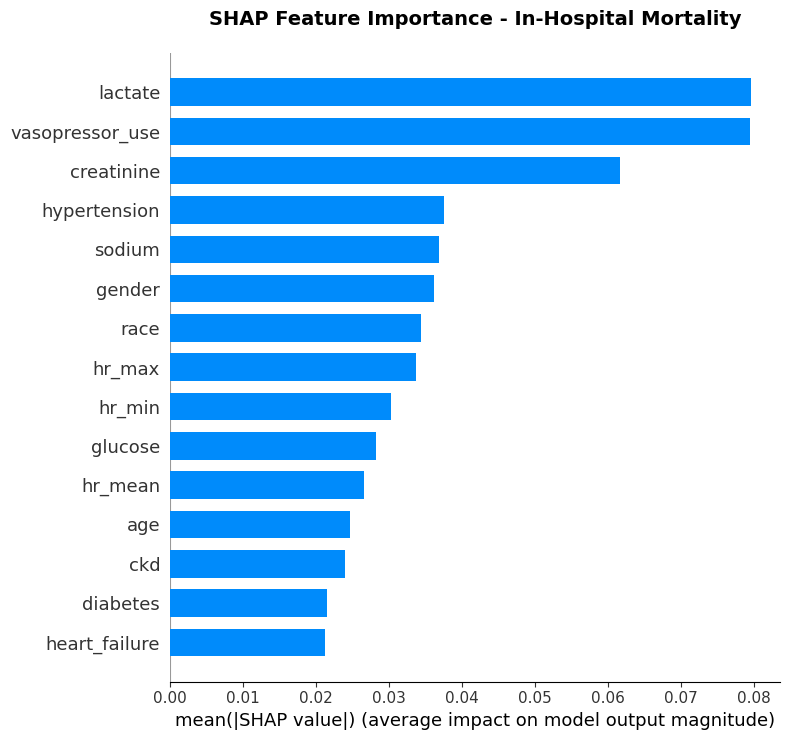


Top 10 Features for In-Hospital Mortality:
        Feature  Importance
        lactate    0.079607
vasopressor_use    0.079459
     creatinine    0.061653
   hypertension    0.037609
         sodium    0.036839
         gender    0.036219
           race    0.034371
         hr_max    0.033741
         hr_min    0.030252
        glucose    0.028201

3. Training MLP Model for: 30-Day Post-Discharge Mortality

Class distribution:
  Negative (0): 6120 (92.77%)
  Positive (1): 477 (7.23%)

Training set size: 5277
Test set size: 1320

Class weights: {0: 0.5390194075587335, 1: 6.907068062827225}

Model Architecture:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 64)             │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,225 (16.50 KB)

 Trainable params: 4,001 (15.63 KB)

 Non-trainable params: 224 (896.00 B)


Training the model...

Epoch 78: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Restoring model weights from the end of the best epoch: 94.

Training completed. Best epoch: 80

4. Model Evaluation
--------------------------------------------------------------------------------

Performance Metrics:
  AUROC: 0.6255
  AUPRC: 0.1223

Classification Report:
              precision    recall  f1-score   support

    Survived       0.94      0.73      0.82      1225
        Died       0.11      0.44      0.18        95

    accuracy                           0.71      1320
   macro avg       0.53      0.59      0.50      1320
weighted avg       0.88      0.71      0.78      1320


5. Generating Visualizations...
--------------------------------------------------------------------------------
Figure saved as: mlp_results_30-day_post-discharge_mortality.png


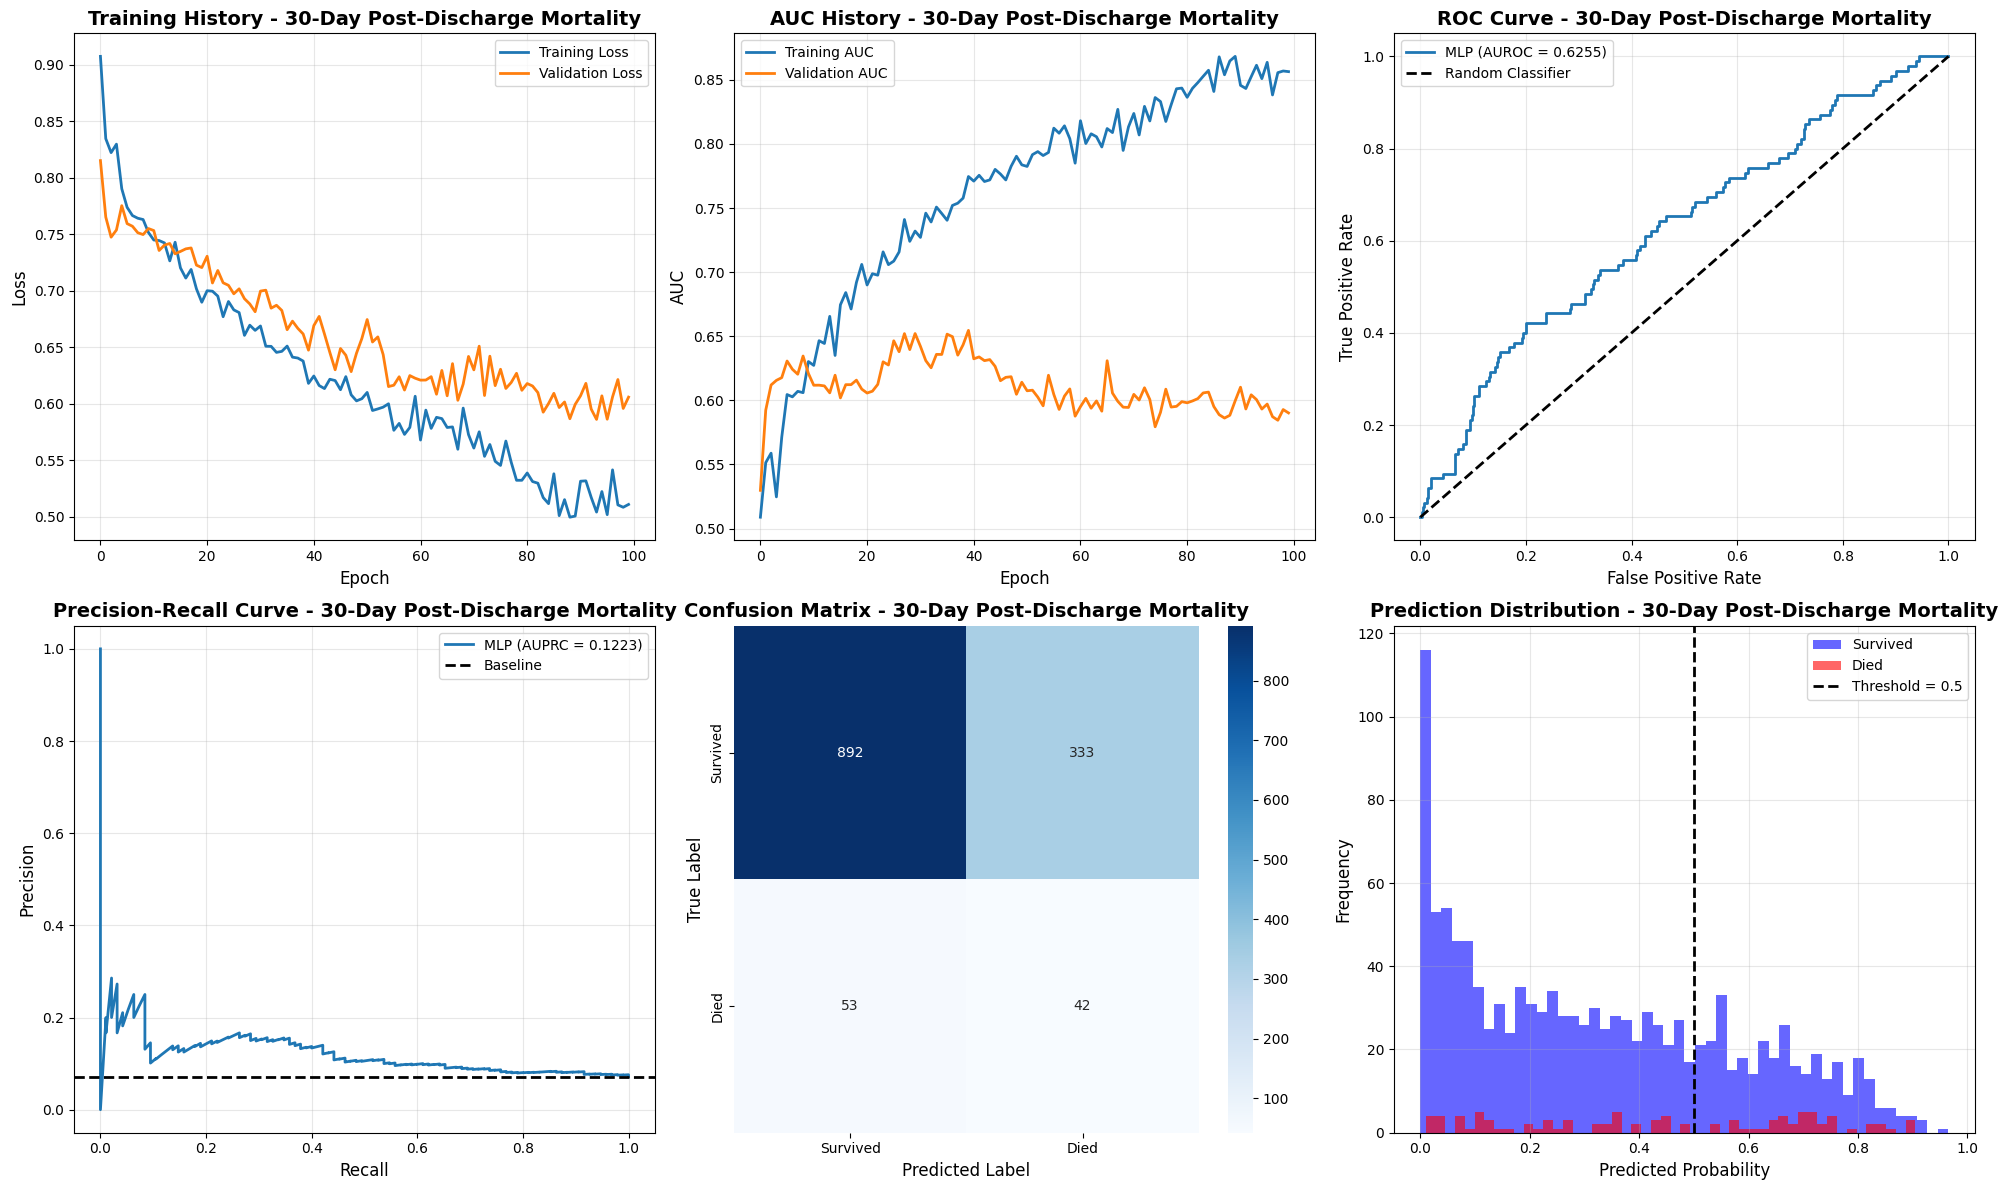


6. Computing SHAP Feature Importance...
--------------------------------------------------------------------------------
Computing SHAP values for all test samples...
SHAP values shape: (1320, 17)
X_test shape: (1320, 17)


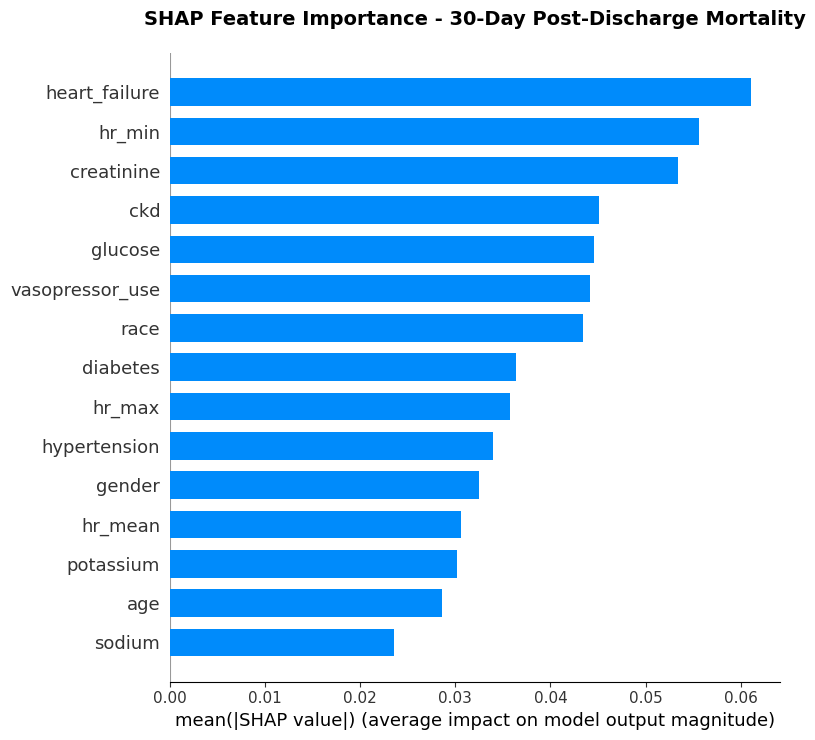


Top 10 Features for 30-Day Post-Discharge Mortality:
        Feature  Importance
  heart_failure    0.061070
         hr_min    0.055584
     creatinine    0.053358
            ckd    0.045124
        glucose    0.044602
vasopressor_use    0.044164
           race    0.043472
       diabetes    0.036348
         hr_max    0.035720
   hypertension    0.033920


In [11]:

#3.build and train mlp models for different prediction horizons
def create_mlp_model(input_dim, hidden_units=[64, 32, 16], dropout_rate=0.3, l2_reg=0.001):
    model = keras.Sequential()
    
    # Input layer
    model.add(layers.Input(shape=(input_dim,)))
    
    # Hidden layers with batch normalization and dropout
    for i, units in enumerate(hidden_units):
        model.add(layers.Dense(
            units, 
            activation='relu',
            kernel_regularizer=regularizers.l2(l2_reg),
            name=f'hidden_{i+1}'
        ))
        model.add(layers.BatchNormalization())
        model.add(layers.Dropout(dropout_rate))
    
    # Output layer
    model.add(layers.Dense(1, activation='sigmoid', name='output'))
    
    # Compile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    
    return model
import shap

# Store results for all prediction horizons
results_summary = {}

# Train models for each prediction horizon
for horizon_name, target_col in target_vars.items():
    print("\n" + "="*80)
    print(f"3. Training MLP Model for: {horizon_name}")
    print("="*80)
    
    # Prepare features and target
    X = data[feature_cols].values
    y = data[target_col].values
    
    # Check class distribution
    unique, counts = np.unique(y, return_counts=True)
    class_dist = dict(zip(unique, counts))
    print(f"\nClass distribution:")
    print(f"  Negative (0): {class_dist.get(0, 0)} ({class_dist.get(0, 0)/len(y)*100:.2f}%)")
    print(f"  Positive (1): {class_dist.get(1, 0)} ({class_dist.get(1, 0)/len(y)*100:.2f}%)")
    
    # Split data into train and test sets (80-20 split)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    
    # Standardize features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    print(f"\nTraining set size: {len(X_train)}")
    print(f"Test set size: {len(X_test)}")
    
    # Calculate class weights to handle imbalanced data
    class_weight = {
        0: len(y_train) / (2 * np.sum(y_train == 0)),
        1: len(y_train) / (2 * np.sum(y_train == 1))
    }
    print(f"\nClass weights: {class_weight}")
    
    # Create MLP model
    model = create_mlp_model(
        input_dim=X_train_scaled.shape[1],
        hidden_units=[64, 32, 16],
        dropout_rate=0.3,
        l2_reg=0.001
    )
    
    print("\nModel Architecture:")
    model.summary()
    
    # Define callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=20,
        restore_best_weights=True,
        verbose=1
    )
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=10,
        min_lr=1e-6,
        verbose=1
    )
    
    # Train the model
    print("\nTraining the model...")
    history = model.fit(
        X_train_scaled, y_train,
        validation_split=0.2,
        epochs=100,
        batch_size=32,
        class_weight=class_weight,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    
    print(f"\nTraining completed. Best epoch: {len(history.history['loss']) - early_stopping.patience}")
    

    print("\n4. Model Evaluation")
    print("-"*80)
    
    # Make predictions
    y_pred_proba = model.predict(X_test_scaled, verbose=0).flatten()
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Calculate metrics
    auroc = roc_auc_score(y_test, y_pred_proba)
    auprc = average_precision_score(y_test, y_pred_proba)
    
    print(f"\nPerformance Metrics:")
    print(f"  AUROC: {auroc:.4f}")
    print(f"  AUPRC: {auprc:.4f}")
    
    # Classification report
    print(f"\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Survived', 'Died']))
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Store results
    results_summary[horizon_name] = {
        'AUROC': auroc,
        'AUPRC': auprc,
        'y_test': y_test,
        'y_pred_proba': y_pred_proba,
        'confusion_matrix': cm,
        'history': history,
        'model': model,  # Store trained model for SHAP
        'X_train_scaled': X_train_scaled,  # Store for SHAP
        'X_test_scaled': X_test_scaled,  # Store for SHAP
        'scaler': scaler  # Store scaler
    }
    

    print("\n5. Generating Visualizations...")
    print("-"*80)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 12))
    
    # 5.1 Training History
    ax1 = plt.subplot(2, 3, 1)
    ax1.plot(history.history['loss'], label='Training Loss', linewidth=2)
    ax1.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
    ax1.set_xlabel('Epoch', fontsize=12)
    ax1.set_ylabel('Loss', fontsize=12)
    ax1.set_title(f'Training History - {horizon_name}', fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)
    
    # 5.2 AUROC History
    ax2 = plt.subplot(2, 3, 2)
    ax2.plot(history.history['auc'], label='Training AUC', linewidth=2)
    ax2.plot(history.history['val_auc'], label='Validation AUC', linewidth=2)
    ax2.set_xlabel('Epoch', fontsize=12)
    ax2.set_ylabel('AUC', fontsize=12)
    ax2.set_title(f'AUC History - {horizon_name}', fontsize=14, fontweight='bold')
    ax2.legend(fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # 5.3 ROC Curve
    ax3 = plt.subplot(2, 3, 3)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, linewidth=2, label=f'MLP (AUROC = {auroc:.4f})')
    ax3.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
    ax3.set_xlabel('False Positive Rate', fontsize=12)
    ax3.set_ylabel('True Positive Rate', fontsize=12)
    ax3.set_title(f'ROC Curve - {horizon_name}', fontsize=14, fontweight='bold')
    ax3.legend(fontsize=10)
    ax3.grid(True, alpha=0.3)
    
    # 5.4 Precision-Recall Curve
    ax4 = plt.subplot(2, 3, 4)
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    ax4.plot(recall, precision, linewidth=2, label=f'MLP (AUPRC = {auprc:.4f})')
    ax4.axhline(y=np.sum(y_test)/len(y_test), color='k', linestyle='--', 
                linewidth=2, label='Baseline')
    ax4.set_xlabel('Recall', fontsize=12)
    ax4.set_ylabel('Precision', fontsize=12)
    ax4.set_title(f'Precision-Recall Curve - {horizon_name}', fontsize=14, fontweight='bold')
    ax4.legend(fontsize=10)
    ax4.grid(True, alpha=0.3)
    
    # 5.5 Confusion Matrix
    ax5 = plt.subplot(2, 3, 5)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True, 
                xticklabels=['Survived', 'Died'],
                yticklabels=['Survived', 'Died'], ax=ax5)
    ax5.set_xlabel('Predicted Label', fontsize=12)
    ax5.set_ylabel('True Label', fontsize=12)
    ax5.set_title(f'Confusion Matrix - {horizon_name}', fontsize=14, fontweight='bold')
    
    # 5.6 Prediction Distribution
    ax6 = plt.subplot(2, 3, 6)
    ax6.hist(y_pred_proba[y_test == 0], bins=50, alpha=0.6, label='Survived', color='blue')
    ax6.hist(y_pred_proba[y_test == 1], bins=50, alpha=0.6, label='Died', color='red')
    ax6.axvline(x=0.5, color='k', linestyle='--', linewidth=2, label='Threshold = 0.5')
    ax6.set_xlabel('Predicted Probability', fontsize=12)
    ax6.set_ylabel('Frequency', fontsize=12)
    ax6.set_title(f'Prediction Distribution - {horizon_name}', fontsize=14, fontweight='bold')
    ax6.legend(fontsize=10)
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(f'mlp_results_{horizon_name.replace(" ", "_").lower()}.png', dpi=300, bbox_inches='tight')
    print(f"Figure saved as: mlp_results_{horizon_name.replace(' ', '_').lower()}.png")
    plt.show()
   
    # 6.shap

    print("\n6. Computing SHAP Feature Importance...")
    print("-"*80)
    
    # Compute SHAP values using ALL test data
    print("Computing SHAP values for all test samples...")
    explainer = shap.DeepExplainer(model, X_train_scaled)
    shap_values = explainer.shap_values(X_test_scaled)
    
    # Handle list output from DeepExplainer
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    
    # Ensure shap_values is 2D
    if len(shap_values.shape) > 2:
        shap_values = shap_values.squeeze()
    
    print(f"SHAP values shape: {shap_values.shape}")
    print(f"X_test shape: {X_test_scaled.shape}")
    
    # Store SHAP values in results
    results_summary[horizon_name]['shap_values'] = shap_values
    
    # Plot SHAP summary (bar plot)
    plt.figure(figsize=(10, 8))
    shap.summary_plot(
        shap_values, 
        X_test_scaled, 
        feature_names=feature_cols,
        plot_type="bar",
        show=False,
        max_display=15
    )
    plt.title(f'SHAP Feature Importance - {horizon_name}', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()
    
    # Calculate and print top 10 features
    mean_abs_shap = np.abs(shap_values).mean(axis=0).flatten()
    
    feature_importance = pd.DataFrame({
        'Feature': feature_cols,
        'Importance': mean_abs_shap
    }).sort_values('Importance', ascending=False)
    
    print(f"\nTop 10 Features for {horizon_name}:")
    print(feature_importance.head(10).to_string(index=False))
    
    # Save to CSV
    feature_importance.to_csv(f'shap_importance_{horizon_name.replace(" ", "_").lower()}.csv', index=False)



Comparison Across Prediction Horizons

MLP Model Performance Summary:
             Prediction Horizon    AUROC    AUPRC
                  ICU Mortality 0.805463 0.459919
          In-Hospital Mortality 0.775611 0.541857
30-Day Post-Discharge Mortality 0.625487 0.122274


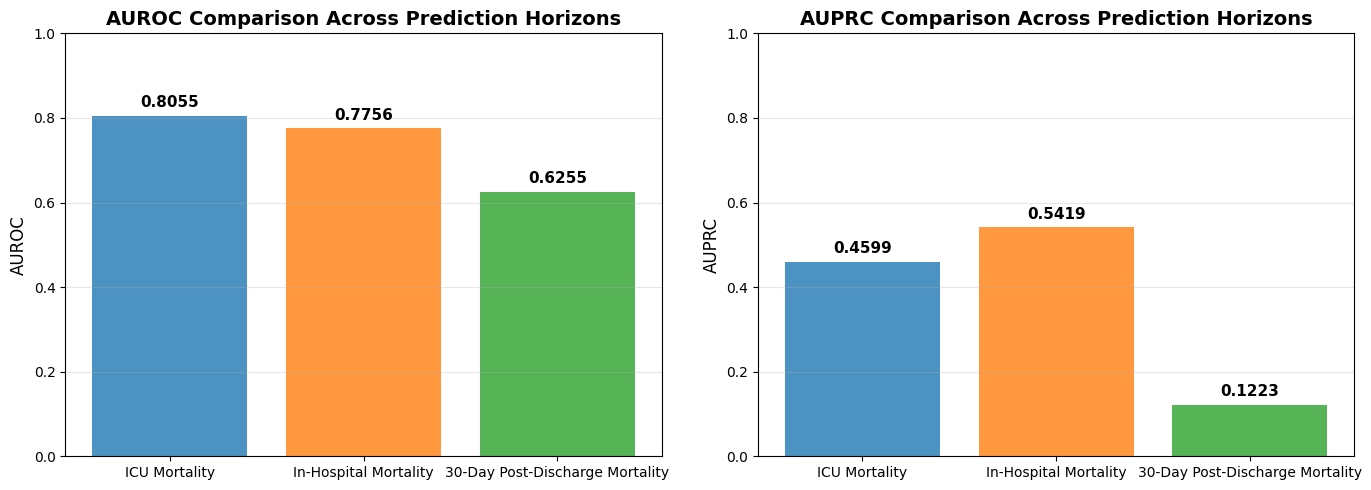

In [12]:
print("Comparison Across Prediction Horizons")
# Create comparison dataframe
comparison_df = pd.DataFrame({
    'Prediction Horizon': list(results_summary.keys()),
    'AUROC': [results_summary[k]['AUROC'] for k in results_summary.keys()],
    'AUPRC': [results_summary[k]['AUPRC'] for k in results_summary.keys()]
})

print("\nMLP Model Performance Summary:")
print(comparison_df.to_string(index=False))

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# AUROC comparison
ax1.bar(comparison_df['Prediction Horizon'], comparison_df['AUROC'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
ax1.set_ylabel('AUROC', fontsize=12)
ax1.set_title('AUROC Comparison Across Prediction Horizons', fontsize=14, fontweight='bold')
ax1.set_ylim([0, 1])
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['AUROC']):
    ax1.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=11, fontweight='bold')

# AUPRC comparison
ax2.bar(comparison_df['Prediction Horizon'], comparison_df['AUPRC'], 
        color=['#1f77b4', '#ff7f0e', '#2ca02c'], alpha=0.8)
ax2.set_ylabel('AUPRC', fontsize=12)
ax2.set_title('AUPRC Comparison Across Prediction Horizons', fontsize=14, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(comparison_df['AUPRC']):
    ax2.text(i, v + 0.02, f'{v:.4f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

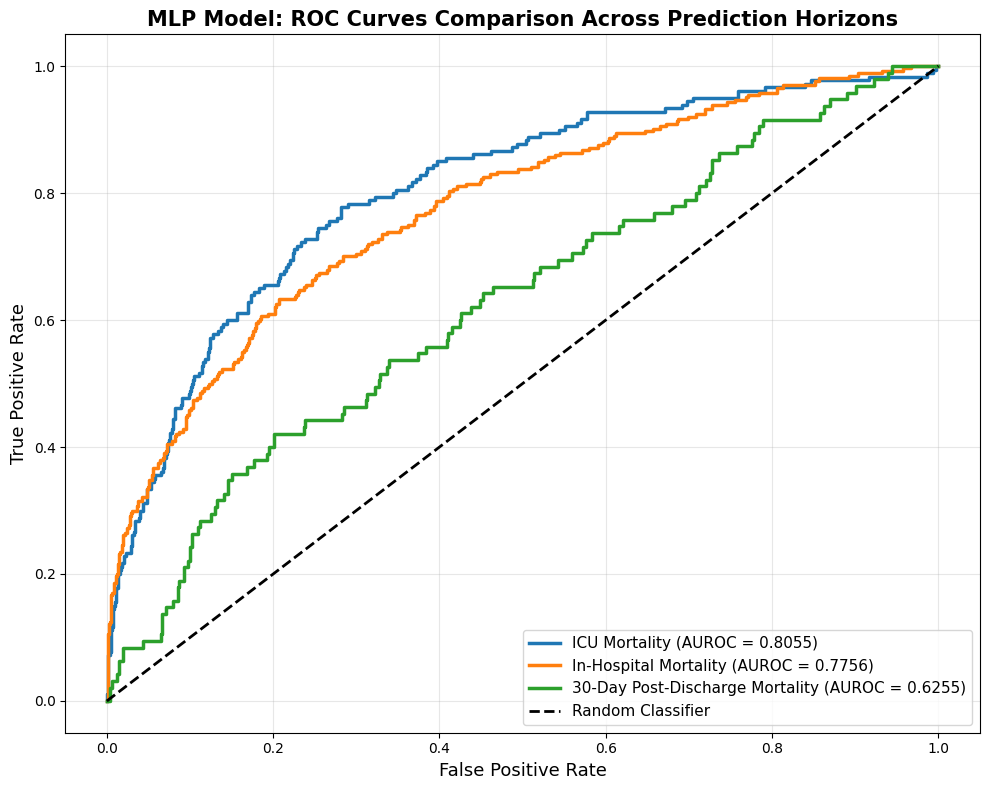

In [13]:
plt.figure(figsize=(10, 8))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']

for i, (horizon_name, results) in enumerate(results_summary.items()):
    fpr, tpr, _ = roc_curve(results['y_test'], results['y_pred_proba'])
    plt.plot(fpr, tpr, linewidth=2.5, label=f'{horizon_name} (AUROC = {results["AUROC"]:.4f})',
             color=colors[i])

plt.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
plt.xlabel('False Positive Rate', fontsize=13)
plt.ylabel('True Positive Rate', fontsize=13)
plt.title('MLP Model: ROC Curves Comparison Across Prediction Horizons', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

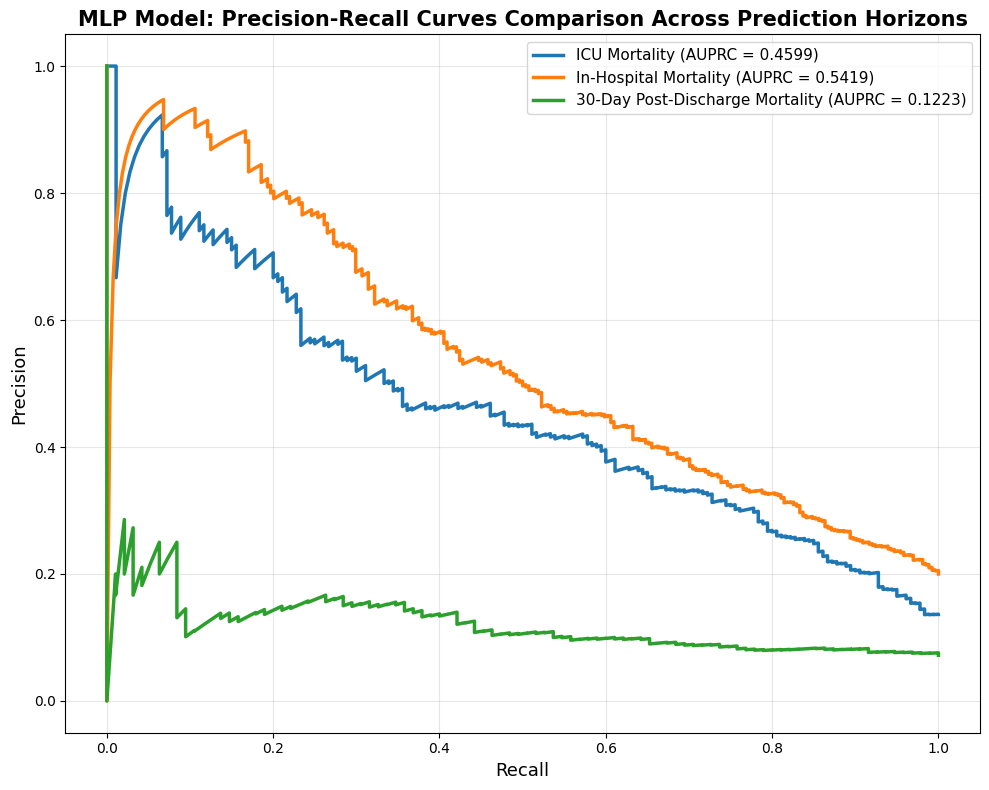

In [14]:
plt.figure(figsize=(10, 8))

for i, (horizon_name, results) in enumerate(results_summary.items()):
    precision, recall, _ = precision_recall_curve(results['y_test'], results['y_pred_proba'])
    baseline = np.sum(results['y_test']) / len(results['y_test'])
    plt.plot(recall, precision, linewidth=2.5, 
             label=f'{horizon_name} (AUPRC = {results["AUPRC"]:.4f})',
             color=colors[i])

plt.xlabel('Recall', fontsize=13)
plt.ylabel('Precision', fontsize=13)
plt.title('MLP Model: Precision-Recall Curves Comparison Across Prediction Horizons', 
          fontsize=15, fontweight='bold')
plt.legend(fontsize=11, loc='best')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Performing DCA for: ICU Mortality
Performing DCA for: In-Hospital Mortality
Performing DCA for: 30-Day Post-Discharge Mortality


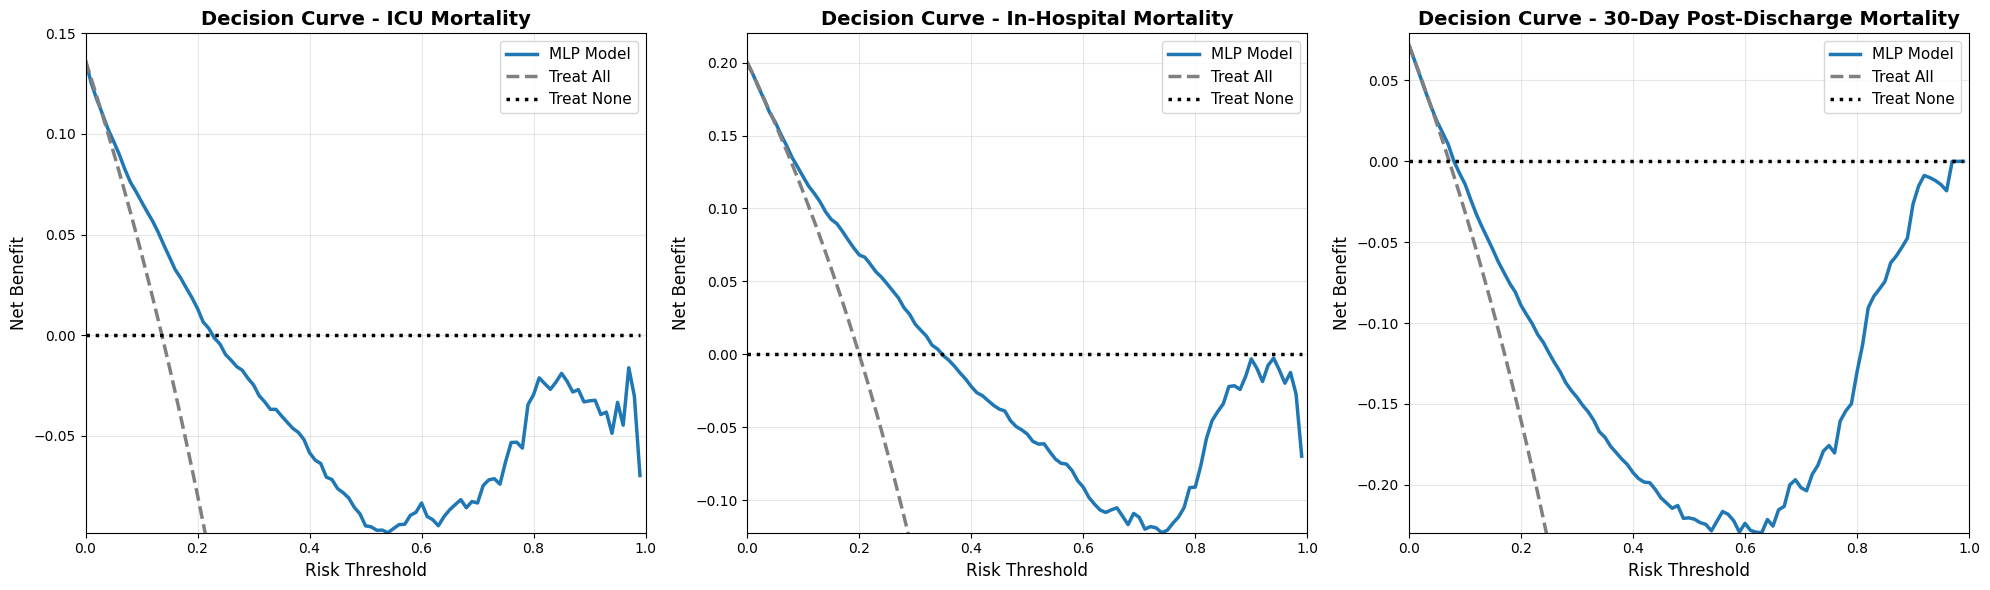

In [15]:
from dcurves import dca, plot_graphs

# Create DCA plots for three prediction horizons
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, (horizon_name, results) in enumerate(results_summary.items()):
    print(f"Performing DCA for: {horizon_name}")
    
    # Prepare data
    dca_df = pd.DataFrame({
        'outcome': results['y_test'],
        'predicted_probability': results['y_pred_proba']
    })
    
    # Perform DCA
    dca_results = dca(
        data=dca_df,
        outcome='outcome',
        modelnames=['predicted_probability'],
        thresholds=np.arange(0, 1.0, 0.01)
    )
    
    # Extract data for plotting
    model_data = dca_results[dca_results['model'] == 'predicted_probability']
    treat_all_data = dca_results[dca_results['model'] == 'all']
    treat_none_data = dca_results[dca_results['model'] == 'none']
    
    # Plot on subplot
    axes[idx].plot(model_data['threshold'], model_data['net_benefit'], 
                   linewidth=2.5, label='MLP Model', color='#1f77b4')
    axes[idx].plot(treat_all_data['threshold'], treat_all_data['net_benefit'], 
                   linewidth=2.5, label='Treat All', color='gray', linestyle='--')
    axes[idx].plot(treat_none_data['threshold'], treat_none_data['net_benefit'], 
                   linewidth=2.5, label='Treat None', color='black', linestyle=':')
    
    axes[idx].set_title(f'Decision Curve - {horizon_name}', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Risk Threshold', fontsize=12)
    axes[idx].set_ylabel('Net Benefit', fontsize=12)
    axes[idx].legend(fontsize=11, loc='upper right')
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xlim([0, 1])
    axes[idx].set_ylim([model_data['net_benefit'].min(), max(model_data['net_benefit'].max(), 
                                     treat_all_data['net_benefit'].max()) * 1.1])

plt.tight_layout()
plt.show()
